1. [Data Description](#data-description) 
2. [Import modules](#import-modules)
3. [Configuration](#configuration)
4. [Data Exploration](#data-exploration)
5. [Train](#train)
6. [Test](#test)

- The dataset is a great collection of images, since the labels are in the following format: 'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle'

- **Quick Summary**
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
    - Metadata: metadata.csv and count.csv provides information about the dataset and train-val-test count information.
    - PPE Class Map: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
    - Difficulty: This is a beginner-friendly dataset on multi-class classification, object detection, and tracking. Annotations are in YoloV8 format. The splits are given in the dataset folder itself with metadata, so anyone can use this data to run models and produce results.


In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


<a id="configuration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Configuration</h2>

In [2]:
warnings.filterwarnings("ignore")

In [3]:
INPUT_DIR = r'E:\hard_hat_detection\archive (4)\css-data'
WORK_DIR = r'data'

<a id="Data Exploration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Data Exploration</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Create data YAML file</b></h4>

In [4]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [5]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check class balance</b></h4>

In [6]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
                
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

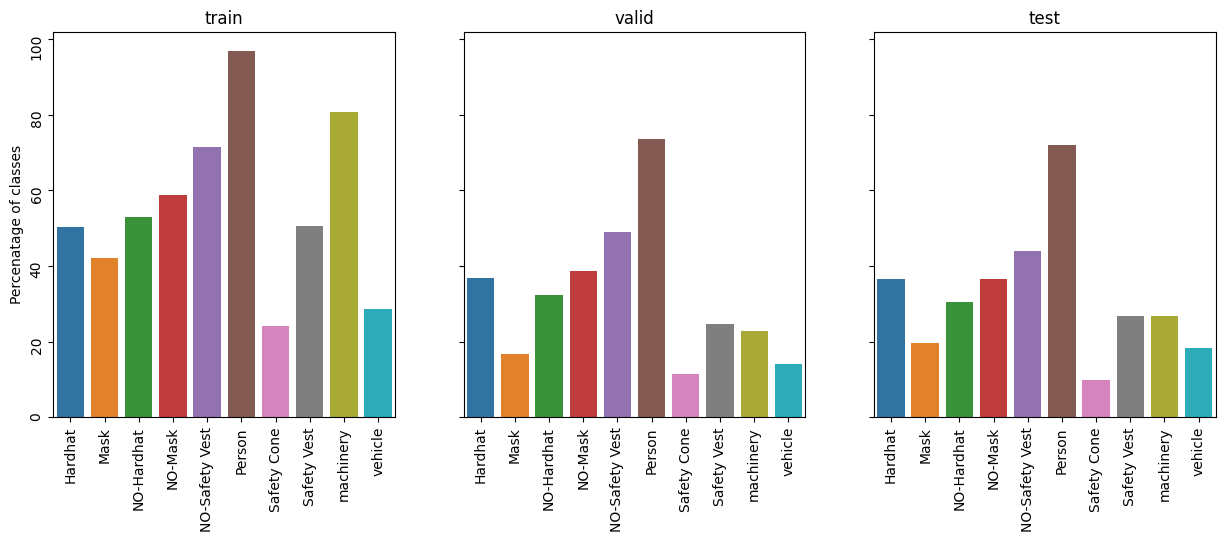

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

- There is imbalance in classes


- Overall class distribution between train, validation and test sets are similar, although validation and test sets have significantly lower percentage of `machinery` class

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check image sizes</b></h4>

In [8]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


- All images have size `640x640`

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check dataset sizes</b></h4>

In [9]:
for mode in ['train', 'valid', 'test']:
    
    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))
        
    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Train</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Arguments for training</b></h4>

- **task**: preform `detect`, `segment` or `classify`
- **imgsz**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **mode**: mode - `train`, `val` or `predict`
- **model**: model to use (could be pre-trained)
- **name**: result names

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Load model<b></h4>

- Load `pre-trained` YOLO-nano model 

In [10]:
model = YOLO('yolov8n.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Train</b></h4>

In [11]:
# KMP_DUPLICATE_LIB_OK=TRUE
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [25]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=10,
            workers=0,
            batch=16,
            mode='train',
            name='yolov8n_v1_train', save=True)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.24 🚀 Python-3.11.8 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/yolov8n_v1_train6/weights/best.pt, data=data\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=yolov8n_v1_train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None

train: Scanning E:\hard_hat_detection\archive (4)\css-data\train\labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ E:\hard_hat_detection\archive (4)\css-data\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ E:\hard_hat_detection\archive (4)\css-data\train\images\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed



val: Scanning E:\hard_hat_detection\archive (4)\css-data\valid\labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8n_v1_train7\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_v1_train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.67G      2.303      2.932      2.243        149        640: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        697      0.377      0.255      0.221     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.96G      1.705      2.271      1.796        125        640: 100%|██████████| 163/163 [01:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        114        697      0.484      0.346      0.336      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.61G      1.541      2.023      1.661        156        640: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        114        697      0.559      0.389      0.415      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.19G      1.452      1.862      1.587        150        640: 100%|██████████| 163/163 [01:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        697       0.62      0.421      0.474      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.83G      1.396      1.725      1.536        128        640: 100%|██████████| 163/163 [01:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        697      0.627      0.464        0.5       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.61G      1.361      1.644      1.495        146        640: 100%|██████████| 163/163 [01:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        114        697      0.684      0.487      0.536      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.31G      1.323      1.555      1.468        108        640: 100%|██████████| 163/163 [01:07<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        114        697      0.714      0.493      0.541      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.84G      1.295      1.503      1.446        212        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        114        697      0.698      0.506      0.559      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.89G      1.278      1.457      1.426        145        640: 100%|██████████| 163/163 [01:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        114        697      0.751      0.496      0.571      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       2.6G      1.259      1.411       1.41        165        640: 100%|██████████| 163/163 [01:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        114        697      0.793      0.506      0.585      0.273



10 epochs completed in 0.196 hours.
Optimizer stripped from runs\detect\yolov8n_v1_train7\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\yolov8n_v1_train7\weights\best.pt, 6.3MB

Validating runs\detect\yolov8n_v1_train7\weights\best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.11.8 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        114        697      0.703      0.505      0.559      0.279
               Hardhat        114         79      0.915      0.658      0.722       0.42
                  Mask        114         21      0.805      0.714      0.736      0.388
            NO-Hardhat        114         69      0.653      0.391      0.412      0.171
               NO-Mask        114         74       0.53      0.311       0.36      0.146
        NO-Safety Vest        114        106      0.822      0.348      0.484       0.21
                Person        114        166      0.722      0.596      0.673      0.321
           Safety Cone        114         44      0.758      0.712      0.753      0.351
           Safety Vest        114         41      0.687      0.589      0.647      0.338
             machinery        114         55      0.597      0.513      0.547      0.294
               vehicle        114         42      0.545      0.214       0.26      0.148
Speed: 0.4ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000023AB53EE950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

<a id="test"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Test</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Select best model</b></h4>

In [27]:
model = YOLO('runs/detect/yolov8n_v1_train7/weights/best.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Make predicitons on test set</b></h4>

In [28]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/82 E:\hard_hat_detection\archive (4)\css-data\test\images\-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Person, 10.5ms
image 2/82 E:\hard_hat_detection\archive (4)\css-data\test\images\000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 NO-Masks, 2 Persons, 11.5ms
image 3/82 E:\hard_hat_detection\archive (4)\css-data\test\images\002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 1 Hardhat, 2 NO-Masks, 1 NO-Safety Vest, 4 Persons, 1 machinery, 16.0ms
image 4/82 E:\hard_hat_detection\archive (4)\css-data\test\images\003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Person, 1 Safety Cone, 10.5ms
image 5/82 E:\hard_hat_detection\archive (4)\css-data\test\images\004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 4 Hardhats, 4 NO-Safety Vests, 6 Persons, 1 Safety Vest, 10.2ms
image 6/82 E:\hard_hat_detection\archive (4)\css-data\test\images\004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 2 Hardhats, 

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Show prediction results</b></h4>

Number of predictions: 82


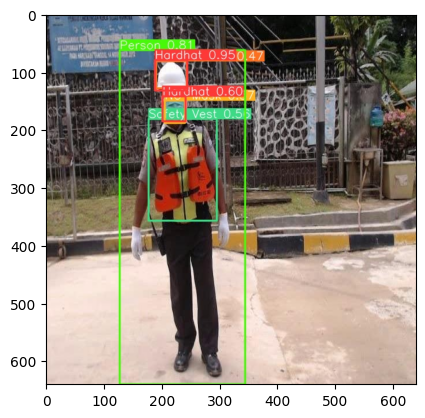

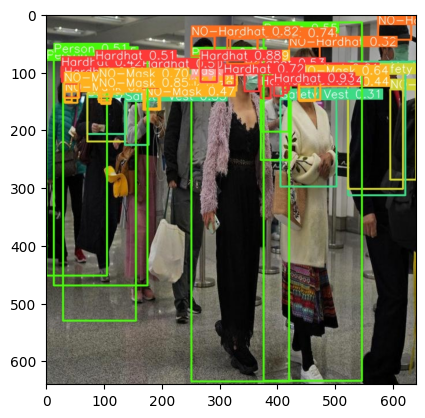

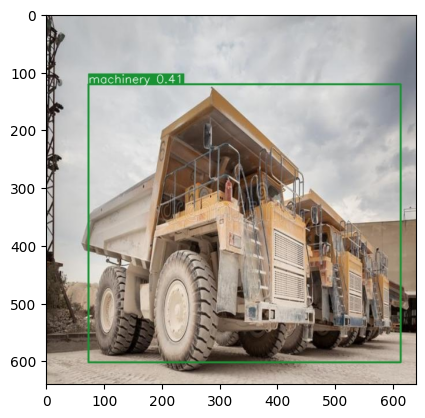

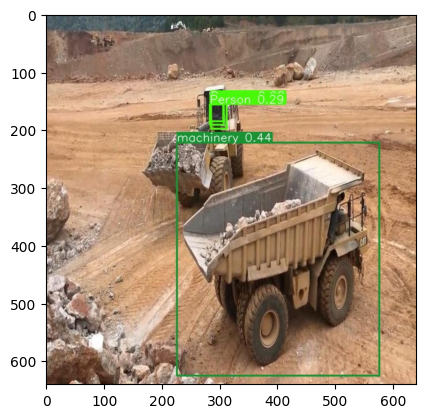

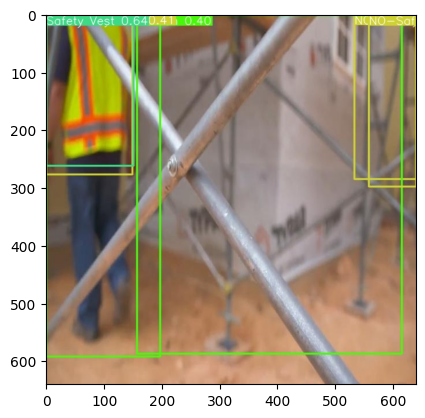

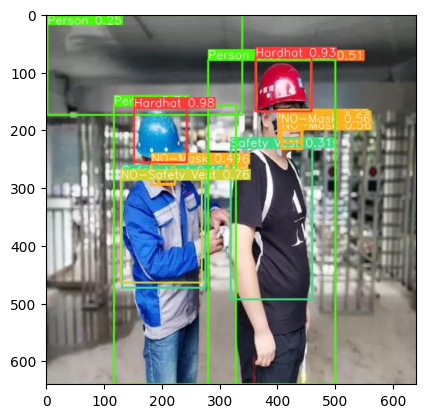

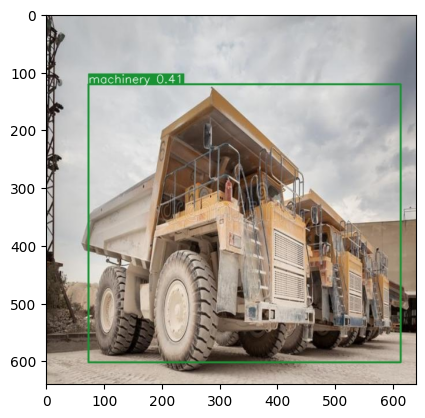

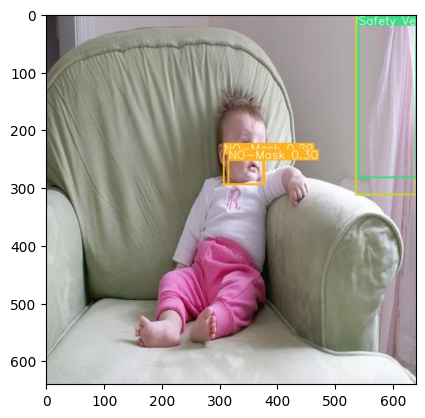

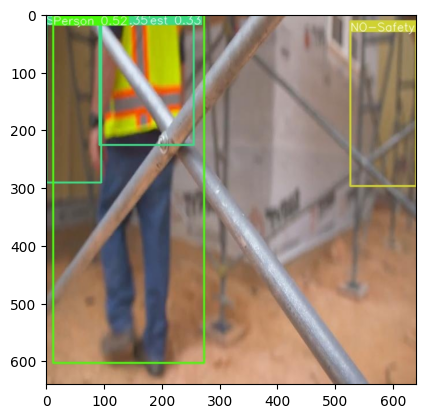

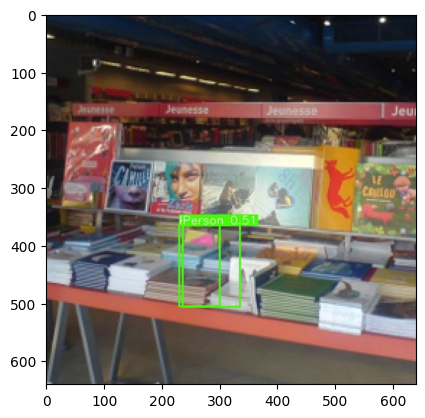

In [29]:
%matplotlib inline

predicitions = glob.glob(os.path.join(r'E:\hard_hat_detection\runs\detect\predict', '*'))
print(f'Number of predictions: {len(predicitions)}')

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [30]:
# export as pytorch model
model.export()

Ultralytics YOLOv8.1.24 🚀 Python-3.11.8 torch-2.2.2 CPU (AMD Ryzen 7 5800H with Radeon Graphics)

PyTorch: starting from 'runs\detect\yolov8n_v1_train7\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)

TorchScript: starting export with torch 2.2.2...
TorchScript: export success ✅ 1.9s, saved as 'runs\detect\yolov8n_v1_train7\weights\best.torchscript' (11.9 MB)

Export complete (3.8s)
Results saved to E:\hard_hat_detection\runs\detect\yolov8n_v1_train7\weights
Predict:         yolo predict task=detect model=runs\detect\yolov8n_v1_train7\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\yolov8n_v1_train7\weights\best.torchscript imgsz=640 data=data\data.yaml  
Visualize:       https://netron.app


'runs\\detect\\yolov8n_v1_train7\\weights\\best.torchscript'